<a href="https://colab.research.google.com/github/Muhammad224172/Demand-forecast-project/blob/main/CS412_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICTING GRADES FROM CHATGTP PROMPTS**

This study explores a novel approach to predicting students' grades by analyzing their interactions with ChatGPT prompts. Leveraging machine learning and natural language processing, we aim to uncover patterns in students' language usage during online conversations and examine its correlation with academic success. This innovative methodology not only showcases the potential of technology in education but also paves the way for personalized interventions based on linguistic interactions.

In [ ]:
# Import libraries
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
import nltk
from nltk.corpus import stopwords
import spacy
from collections import Counter
# Download NLTK resources
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install skrebate


  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=b2b6cf31ca469c9b2042f0c5434edb269bf8986ad9b6038db05925e60c591690
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built skrebate


In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
data_path = "data/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:20<00:00,  6.07it/s]


In [ ]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### **Prompt Matching Prompt matching with questions**
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching
#### **Our approach**
use word2vec instead of tf_idf here

Word2Vec is a popular word embedding technique that represents words as vectors in a continuous vector space. Developed by researchers at Google, Word2Vec captures semantic relationships between words and is widely used in natural language processing tasks. The approach involves training a neural network to learn distributed representations of words based on their context in a given corpus.

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [ ]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [ ]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
################################################################################
################################################################################
#I am trying to use word2vec instead of tf_idf here
#THIS IS OUR ATTEMPT IN IMPROVING CODE
################################################################################
################################################################################

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd

# Function to preprocess text for Word2Vec
def preprocess_text(text):
    # Convert text to lowercase and split it into words
    words = text.lower().split()
    # Remove stop words
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return words
keywords = []
prompts = []
code2prompts = defaultdict(list)
for code, convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
            keywords.append(conv["text"])
    code2prompts[code] = user_prompts

# Create a list of sentences for Word2Vec training
sentences = [preprocess_text(prompt) for prompt in prompts + questions]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create DataFrames for Word2Vec vectors
questions_word2vec = pd.DataFrame([word2vec_model.wv[preprocess_text(question)].mean(axis=0) for question in questions])

code2prompts_word2vec = {}
for code, user_prompts in code2prompts.items():
    prompts_word2vec = [word2vec_model.wv[preprocess_text(prompt)].mean(axis=0) for prompt in user_prompts if preprocess_text(prompt)]
    if prompts_word2vec:
        code2prompts_word2vec[code] = pd.DataFrame(prompts_word2vec)
    else:
        print(f"This file is erronous: {code}")

# Concatenate DataFrames along rows and handle NaN values
code2prompts_word2vec = {code: df.fillna(0) for code, df in code2prompts_word2vec.items()}

This file is erronous: 139235c7-736c-4237-92f0-92e8c116832c
This file is erronous: 668ad17e-0240-49f7-b5a7-d22e502554c6
This file is erronous: b0640e51-6879-40cb-a4f5-329f952ef99d
This file is erronous: da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
################################################################################
################################################################################
#THIS IS OUR ATTEMPT IN IMPROVING CODE
################################################################################
################################################################################

code2prompts_word2vec["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.037684,0.467180,0.346941,-0.275322,-0.066601,-0.824483,-0.076390,0.934138,-0.279298,-0.370610,...,0.453782,0.084193,0.032508,-0.064857,0.638791,0.415990,0.217131,-0.425445,0.109238,-0.170812
1,-0.067381,0.402569,0.650277,-0.235120,-0.189603,-0.670344,0.025720,0.678174,-0.033867,-0.442069,...,0.622263,-0.196562,0.071827,-0.167627,0.638625,0.394581,0.425692,-0.179643,0.167583,0.143140
2,0.313579,0.864330,-0.562495,-0.447982,0.612296,-0.898349,-0.482475,1.971794,0.137905,-0.625055,...,1.370492,0.828018,0.135201,0.055339,1.325663,1.029480,-0.220998,-0.642837,-0.055011,0.040751
3,-0.566181,0.733509,0.090963,-0.759614,-0.109542,-1.276682,-0.247960,1.994994,-0.019042,-1.338943,...,1.625675,0.668443,-0.252908,-0.307594,1.853674,1.131366,-0.552972,-0.557308,-0.017428,-0.334125
4,-0.363880,0.492403,0.103524,-0.336275,-0.128480,-0.825382,-0.149833,1.122765,-0.057441,-0.818084,...,0.990042,0.435129,-0.191751,-0.158388,1.077820,0.701144,-0.234547,-0.369347,0.014466,-0.203426


In [ ]:
################################################################################
################################################################################
#THIS IS OUR ATTEMPT IN IMPROVING CODE
################################################################################
################################################################################

code2prompts_word2vec["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 100)

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################

from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between questions_word2vec and each code's prompts_word2vec
code2similarity = {}

for code, prompts_df in code2prompts_word2vec.items():
    similarity_scores = cosine_similarity(prompts_df, questions_word2vec)
    # Average similarity scores across prompts for each code
    avg_similarity_score = similarity_scores.mean(axis=0)
    code2similarity[code] = avg_similarity_score

# Create a DataFrame to store the similarity scores
similarity_df = pd.DataFrame(code2similarity, index=questions)

# Display the resulting DataFrame
print(similarity_df)

                                                    0031c86e-81f4-4eef-9e0e-28037abf9883  \
Initialize\n*   First make a copy of the notebo...                              0.880810   
Load training dataset (5 pts)\n    *  Read the ...                              0.809838   
Understanding the dataset & Preprocessing (15 p...                              0.815758   
Set X & y, split data (5 pts)\n\n*   Shuffle th...                              0.834712   
Features and Correlations (10 pts)\n\n* Correla...                              0.831215   
Tune Hyperparameters (20 pts)\n* Choose 2 hyper...                              0.698800   
Re-train and plot the decision tree with the hy...                              0.707167   
Test your classifier on the test set (20 pts)\n...                              0.755504   
Find the information gain on the first split (1...                              0.728214   

                                                    0225686d-b825-4cac-8691-3a3

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################

code2questionmapping = dict()
for code, cosine_scores in similarity_df.items():
    code2questionmapping[code] = similarity_df[code].tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.880810,0.809838,0.815758,0.834712,0.831215,0.698800,0.707167,0.755504,0.728214
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.829305,0.798472,0.771019,0.768506,0.734945,0.743271,0.761876,0.788564,0.751294
2,041f950b-c013-409a-a642-cffff60b9d4b,0.890235,0.812697,0.746247,0.768088,0.785897,0.751365,0.754584,0.783462,0.734562
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.848536,0.807422,0.811072,0.806117,0.768770,0.737203,0.744227,0.781528,0.748547
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.871876,0.815111,0.801018,0.802078,0.775701,0.753020,0.754832,0.787166,0.759002
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.866041,0.823305,0.800968,0.804203,0.761365,0.744463,0.775285,0.805229,0.800763
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.864564,0.809377,0.826436,0.812966,0.767601,0.734194,0.727395,0.769411,0.738311
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.874031,0.822742,0.795445,0.807634,0.769684,0.745580,0.757151,0.791423,0.761728
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.871850,0.841092,0.812316,0.817141,0.755865,0.781876,0.794741,0.823759,0.780811


#### **Feature Engineering**
- Number of prompts that a users asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

#### **Feature Engineering**
**Approach**
Extracting more features that can be useful to the model.
Consider the entire all prompt. we would like to know the most frequent keywords and then use this as features in our model. most frequent words should have a good level of exlainablity for the target values.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
import spacy

# Download NLTK resources
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Increase spaCy max_length limit
nlp.max_length = 4418961   # Adjust this value based on your needs

def preprocess_text_as_list(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize using spaCy
    tokens = nlp(text)
    # Lemmatization and remove stop words
    tokens = [token.lemma_ for token in tokens if token.lemma_ not in stopwords.words("english")]

    return tokens

# Example
# Convert keywords to string first
keywords_str = str(keywords)

# Preprocess the keywords as a list of tokens
processed_tokens = preprocess_text_as_list(keywords_str)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Get the top 3 most frequent words in each prompt
from collections import Counter

def most_common_words(tokens, top_n=5, min_length=6, exclude_spaces=True):
    # Filter tokens based on length and spaces
    filtered_tokens = [token for token in tokens if len(token) >= min_length and (not exclude_spaces or ' ' not in token)]

    # Use Counter to count the occurrences of each word
    word_counts = Counter(filtered_tokens)

    # Get the top N most common words
    top_words = word_counts.most_common(top_n)

    return top_words

# Example usage:
top_words_result = most_common_words(processed_tokens, top_n=30, min_length=6, exclude_spaces=True)

print("The top 30 most frequently appearing words (more than 5 letters and no spaces) are:")
for word, count in top_words_result:
    print(f"{word}: {count} times")

The top 30 most frequently appearing words (more than 5 letters and no spaces) are:
feature: 1172 times
hyperparameter: 1081 times
correlation: 958 times
adelie: 840 times
dataset: 732 times
variable: 727 times
choose: 607 times
column: 593 times
import: 548 times
chinstrap: 537 times
target: 490 times
accuracy: 482 times
decision: 416 times
calculate: 409 times
penguin: 402 times
function: 385 times
result: 343 times
strong: 342 times
information: 335 times
entropy: 335 times
healthmetric: 321 times
hypothetical: 316 times
gentoo: 313 times
health: 290 times
follow: 282 times
number: 277 times
nonnull: 266 times
recent: 261 times
overweight: 247 times
display: 232 times


In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################
keywords2search = [ "hyperparameter", "correlation", "adelie", "variable","dataset", "choose", "chinstrap" , 'import' , "error" , "no" , "next" , "hypothetica"]

keywords2search = [k.lower() for k in keywords2search]

In [ ]:
################################################################################
################################################################################
#IMPROVING CODE
################################################################################
################################################################################

### Using pattern based approach in the structure of the sentences to tell if it is an error or not

code2features = defaultdict(lambda : defaultdict(int))

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # check if it is an error term or not ## improvement
            #if is_fix_error_prompt(text) == True :
             #   code2features[code]['error']  = code2features[code]['error'] +1
            #else:
             #  code2features[code]['error']  = code2features[code]['error']

            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)


        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)



        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#hyperparameter,#correlation,#adelie,#variable,#dataset,#choose,#chinstrap,#import,#error,#no,#next,#hypothetica,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,4.0,0.0,11.0,8.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,2.0,5.0,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,1.0,6.0,9.0,2.0,1.0,10.0,3.0,0.0,0.0,0.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,3.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,2.0,11.0,0.0,10.0,9.0,5.0,0.0,6.0,1.0,5.0,0.0,0.0,0.017986,18.850913


In [ ]:
# reading the scores
scores = pd.read_csv("/content/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


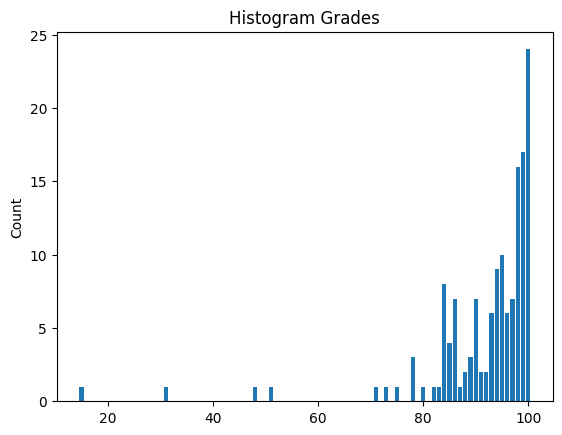

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#hyperparameter,#correlation,#adelie,#variable,#dataset,#choose,#chinstrap,#import,#error,#no,#next,#hypothetica,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,4.0,0.0,11.0,8.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,2.0,5.0,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,1.0,6.0,9.0,2.0,1.0,10.0,3.0,0.0,0.0,0.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,3.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,2.0,11.0,0.0,10.0,9.0,5.0,0.0,6.0,1.0,5.0,0.0,0.0,0.017986,18.850913


In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#hyperparameter,#correlation,#adelie,#variable,#dataset,#choose,#chinstrap,#import,...,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,4.0,0.0,11.0,8.0,1.0,1.0,0.0,...,212.206370,0.880810,0.809838,0.815758,0.834712,0.831215,0.698800,0.707167,0.755504,0.728214
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,2.0,5.0,10.0,4.0,2.0,0.0,...,113.633582,0.829305,0.798472,0.771019,0.768506,0.734945,0.743271,0.761876,0.788564,0.751294
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,1.0,6.0,9.0,2.0,1.0,10.0,...,17.187601,0.890235,0.812697,0.746247,0.768088,0.785897,0.751365,0.754584,0.783462,0.734562
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,3.0,0.0,2.0,2.0,0.0,1.0,0.0,...,107.092566,0.848536,0.807422,0.811072,0.806117,0.768770,0.737203,0.744227,0.781528,0.748547
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,2.0,11.0,0.0,10.0,9.0,5.0,0.0,6.0,...,18.850913,0.871876,0.815111,0.801018,0.802078,0.775701,0.753020,0.754832,0.787166,0.759002


In [ ]:
# Merge the Features
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#hyperparameter,#correlation,#adelie,#variable,#dataset,#choose,#chinstrap,#import,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,4.0,0.0,11.0,8.0,1.0,1.0,0.0,...,0.880810,0.809838,0.815758,0.834712,0.831215,0.698800,0.707167,0.755504,0.728214,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,2.0,0.0,2.0,5.0,10.0,4.0,2.0,0.0,...,0.829305,0.798472,0.771019,0.768506,0.734945,0.743271,0.761876,0.788564,0.751294,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,1.0,6.0,9.0,2.0,1.0,10.0,...,0.890235,0.812697,0.746247,0.768088,0.785897,0.751365,0.754584,0.783462,0.734562,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,3.0,0.0,2.0,2.0,0.0,1.0,0.0,...,0.848536,0.807422,0.811072,0.806117,0.768770,0.737203,0.744227,0.781528,0.748547,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,2.0,11.0,0.0,10.0,9.0,5.0,0.0,6.0,...,0.871876,0.815111,0.801018,0.802078,0.775701,0.753020,0.754832,0.787166,0.759002,100.0


In [ ]:
# Set the features and target variables
X = temp_df[temp_df.columns[1:-1]]
y = temp_df["grade"]

print(X.shape, y.shape)

(122, 24) (122,)


#### **Apply feature subset selection algorithm**
Usinf the Information gain from each feature to select the best features for modelling

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (97, 24)
Shape of X_test: (25, 24)
Shape of y_train: (97,)
Shape of y_test: (25,)


In [ ]:
X_train.head()

,#user_prompts,#hyperparameter,#correlation,#adelie,#variable,#dataset,#choose,#chinstrap,#import,#error,...,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
50,20.0,6.0,1.0,0.0,4.0,7.0,3.0,0.0,4.0,0.0,...,101.948312,0.874483,0.832242,0.808677,0.808695,0.764420,0.771967,0.782544,0.812873,0.779305
121,15.0,2.0,1.0,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,193.158082,0.829908,0.811461,0.808592,0.810319,0.749774,0.706566,0.756001,0.801286,0.772119
109,19.0,0.0,0.0,12.0,4.0,7.0,0.0,0.0,0.0,4.0,...,150.338018,0.834648,0.790143,0.781570,0.768278,0.715140,0.687293,0.708333,0.752418,0.731201
43,20.0,1.0,0.0,1.0,6.0,15.0,2.0,1.0,1.0,5.0,...,132.624725,0.843310,0.791155,0.746726,0.737116,0.710993,0.725105,0.736502,0.768051,0.717257
116,35.0,1.0,0.0,2.0,9.0,6.0,0.0,1.0,2.0,3.0,...,82.287366,0.819686,0.788038,0.777198,0.785170,0.741932,0.685901,0.715784,0.755604,0.736511


In [ ]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define the problem as a maximization problem
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define the evaluation function (fitness function)
def evaluate(individual, X, y, clf):
    # Select features based on the individual's genes
    selected_features = [feature for feature, include in zip(range(len(individual)), individual) if include]

    if not selected_features:
        # Ensure at least one feature is selected
        return 0.0,

    # Evaluate the fitness using cross-validation
    clf.fit(X.iloc[:, selected_features], y)
    scores = cross_val_score(clf, X.iloc[:, selected_features], y, cv=5)

    return np.mean(scores),

# Define genetic algorithm parameters
population_size = 50
generations = 10
crossover_prob = 0.8
mutation_prob = 0.2

# Initialize population and toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.choice, [0, 1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate, X=X_train, y=y_train, clf=RandomForestClassifier())
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize the population
population = toolbox.population(n=population_size)

# Run the genetic algorithm
algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2*population_size,
                          cxpb=crossover_prob, mutpb=mutation_prob, ngen=generations, stats=None, halloffame=None)

# Extract the best individual from the final population
best_individual = tools.selBest(population, k=1)[0]

# Extract the selected features based on the best individual's genes
selected_features_final = [feature for feature, include in zip(range(len(best_individual)), best_individual) if include]

# Print the selected features
print("Selected Features:", selected_features_final)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

gen	nevals
0  	50    


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

1  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

2  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

3  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

4  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

5  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

6  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

7  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

8  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

9  	100   


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

10 	100   
Selected Features: [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 16, 18, 23]


In [ ]:
# Information Gain filter
info_gain_selector = SelectKBest(score_func=mutual_info_classif, k=5)
X_info_gain = info_gain_selector.fit_transform(X_train, y_train)

print("\nInformation Gain Selected Features:")
print(X.columns[info_gain_selector.get_support()])


Information Gain Selected Features:
Index(['#hyperparameter', '#adelie', '#choose', '#next', 'Q_4'], dtype='object')


In [ ]:
selected_from_genetic = ['#hyperparameter', '#correlation', '#adelie', '#variable', '#dataset', '#choose', '#chinstrap', '#import', 'Q_0', 'Q_4']
selected_from_infogain =['#adelie', '#choose', '#chinstrap', '#error', 'Q_4']
selected = (set(selected_from_genetic) | set(selected_from_infogain))
# Print the union of both sets directly
print("Selected features = " , selected  )



Selected features =  {'#correlation', '#dataset', 'Q_0', '#adelie', '#import', '#error', '#chinstrap', '#hyperparameter', 'Q_4', '#variable', '#choose'}


In [ ]:
#select best subsets according to selection
X_train_selected = X_train[selected]
X_test_selected = X_test[selected]

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train_selected.shape)
print("Shape of X_test:", X_test_selected.shape)

Shape of X_train: (97, 11)
Shape of X_test: (25, 11)


<ipython-input-37-5303da4fc876>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_selected = X_train[selected]
<ipython-input-37-5303da4fc876>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_selected = X_test[selected]


### **Model Building**
build an appropriate machine learning model to predict the scores of students from the seleted features



#### **Approach**
compare Accuracy with XGBOOST and  Linear regression with Lasso regression (skip feature subset selection in this case). Lasso regressison will provide another level of feature selection.

In [ ]:
# Standardize features (important for Lasso regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define a range of alpha values
alphas = np.arange(0.1, 3.1, 0.1)

# Lists to store results
mse_values = []
adjusted_r2_values = []

# Iterate over alpha values
for alpha in alphas:
    # Create and train Lasso regression model
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred_lasso = lasso_model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred_lasso)
    r2 = r2_score(y_test, y_pred_lasso)

    # Calculate adjusted R-squared
    n = X_test_scaled.shape[0]
    k = X_test_scaled.shape[1]
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - k - 1))

    # Append results to lists
    mse_values.append(mse)
    adjusted_r2_values.append(adjusted_r2)

ZeroDivisionError: division by zero

In [ ]:
# Print alpha values along with their corresponding adjusted R2 and RMSE
print("Alpha\tAdjusted R2\tRMSE")
print("----------------------------------")

for i, alpha in enumerate(alphas):
    # Create and train Lasso regression model
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred_lasso = lasso_model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred_lasso)
    r2 = r2_score(y_test, y_pred_lasso)

    # Calculate adjusted R-squared
    n = X_test_scaled.shape[0]
    k = X_test_scaled.shape[1]
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - k - 1))

    # Print alpha, adjusted R2, and RMSE
    print(f"{alpha:.2f}\t{adjusted_r2:.4f}\t\t{mse:.4f}")


Alpha	Adjusted R2	RMSE
----------------------------------


ZeroDivisionError: division by zero

In [ ]:
# Using XGboost ro predict scores of students
regressor = xgb.XGBRegressor(booster = "gbtree", objective='reg:squarederror', max_depth=10, random_state=0)
#fit the model
regressor.fit(X_train_selected, y_train)





XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [ ]:
################################################################################
################################################################################
#THIS IS OUR ATTEMPT IN IMPROVING CODE
################################################################################
################################################################################

# Prediction
y_train_pred = regressor.predict(X_train_selected)
y_test_pred = regressor.predict(X_test_selected)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 5.45817136898944e-07
MSE TEST: 83.66114384832152
R2 Train: 0.9999999966600417
R2 TEST: 0.2547927072200076


In [ ]:
print(temp_df)

                                     code  #user_prompts  #hyperparameter  \
0    0031c86e-81f4-4eef-9e0e-28037abf9883           14.0              0.0   
1    0225686d-b825-4cac-8691-3a3a5343df2b           18.0              2.0   
2    041f950b-c013-409a-a642-cffff60b9d4b            9.0              1.0   
3    04f91058-d0f8-4324-83b2-19c671f433dc           20.0              0.0   
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0              2.0   
..                                    ...            ...              ...   
135  f24219d6-07f0-4baf-80ac-18475dc5b66f           21.0              1.0   
136  f2f18684-4a16-4c05-a2d1-c0f96d1de869           71.0              1.0   
137  f852596d-fdca-45aa-9050-d4f76ce6a53c           30.0              1.0   
138  f8ec3336-fd48-4654-ad98-62ccfb96d096           14.0              1.0   
139  fb8de815-224c-4d06-9fd4-7156d1a9920d           31.0              1.0   

     #correlation  #adelie  #variable  #dataset  #choose  #chinstrap  #impo